<a href="https://colab.research.google.com/github/leburik12/-machine-learning-MRI-neuroimaging-classification-using-SVM-Random-Forest-XGBoost-and-KNN/blob/main/machine_learning_MRI_neuroimaging_classification_using_SVM_Random_Forest_XGBoost_and_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install xgboost

In [2]:
import os
import pandas as pd
import zipfile
from typing import Dict, Tuple, Optional, Union, List,Any
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ( accuracy_score,balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef, confusion_matrix,classification_report)
from sklearn.pipeline import Pipeline
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T
from abc import ABC, abstractmethod
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
import time
from tqdm import tqdm
from dataclasses import dataclass, field
import multiprocessing
from scipy.ndimage import gaussian_filter
import torchvision.transforms.functional as TF
import random
from skimage.feature import hog, local_binary_pattern,graycomatrix,graycoprops
from scipy.ndimage import binary_opening,label
import cv2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kirubelawoke","key":"d2a091bafb95821cc42b8946736798fc"}'}

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle

#!kaggle datasets list

In [5]:
!kaggle datasets download -d ninadaithal/imagesoasis


Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 99% 1.22G/1.23G [00:06<00:00, 242MB/s]
100% 1.23G/1.23G [00:06<00:00, 216MB/s]


In [6]:
with zipfile.ZipFile("imagesoasis.zip", "r") as zip_ref:
  zip_ref.extractall("imagesoasis")

In [7]:

for dirpath, dirnames, filenames in os.walk("imagesoasis"):
  print(f"{dirpath}: {len(filenames)} files")


imagesoasis: 0 files
imagesoasis/Data: 0 files
imagesoasis/Data/Non Demented: 67222 files
imagesoasis/Data/Mild Dementia: 5002 files
imagesoasis/Data/Very mild Dementia: 13725 files
imagesoasis/Data/Moderate Dementia: 488 files


In [8]:
folder_to_check = "imagesoasis/Data/Mild Dementia"

from collections import Counter
extensions = []


for fname in os.listdir(folder_to_check):
  ext = os.path.splitext(fname)[1].lower()
  extensions.append(ext)

print("File extensions found:", Counter(extensions))

File extensions found: Counter({'.jpg': 5002})


In [9]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [10]:
# Define data directory
base_dir = "imagesoasis/Data"
categories = os.listdir(base_dir)
print(f" Categories in detail :-  {categories}")

label_map = {
    "Non Demented": 0,
    "Very mild Dementia": 1,
    "Mild Dementia": 2,
    "Moderate Dementia":3
}

# Collect image paths and corresponding labels
data = []

for category in categories:
  class_dir = os.path.join(base_dir, category)
  label = label_map[category]
  for fname in os.listdir(class_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
      fpath = os.path.join(class_dir, fname)
      data.append((fpath, label))

df = pd.DataFrame(data, columns=['image_path', 'label'])
print(f"Shape :  {df.shape}")
print(f"\nHead: \n{df.head(5)}")
print(f"\nTail: \n{df.tail(5)}")
print(f"\nData Type: \n{df.dtypes}")

 Categories in detail :-  ['Non Demented', 'Mild Dementia', 'Very mild Dementia', 'Moderate Dementia']
Shape :  (86437, 2)

Head: 
                                          image_path  label
0  imagesoasis/Data/Non Demented/OAS1_0061_MR1_mp...      0
1  imagesoasis/Data/Non Demented/OAS1_0047_MR1_mp...      0
2  imagesoasis/Data/Non Demented/OAS1_0145_MR2_mp...      0
3  imagesoasis/Data/Non Demented/OAS1_0188_MR1_mp...      0
4  imagesoasis/Data/Non Demented/OAS1_0070_MR1_mp...      0

Tail: 
                                              image_path  label
86432  imagesoasis/Data/Moderate Dementia/OAS1_0351_M...      3
86433  imagesoasis/Data/Moderate Dementia/OAS1_0308_M...      3
86434  imagesoasis/Data/Moderate Dementia/OAS1_0351_M...      3
86435  imagesoasis/Data/Moderate Dementia/OAS1_0351_M...      3
86436  imagesoasis/Data/Moderate Dementia/OAS1_0351_M...      3

Data Type: 
image_path    object
label          int64
dtype: object


In [11]:
@dataclass
class DatasetConfig:
  """Configuratoin class for dataset parameters"""
  base_dir: str = "imagesoasis/Data"
  valid_extensions: Tuple[str] = ('.png', '.jpg', '.jpeg,', '.webp')
  num_workers: int = max(1, multiprocessing.cpu_count() - 2)
  random_seed: int = 42
  test_size: float = 0.2

class MedicalImageDatasetBuilder:
  def __init__(self, config: DatasetConfig = DatasetConfig()):
    self.config = config
    self.label_map = {
        "Non Demented": 0,
        "Very mild Dementia": 1,
        "Mild Dementia": 2,
        "Moderate Dementia": 3
    }
    self._validate_structure()

  def _validate_structure(self) -> None:
    if not os.path.exists(self.config.base_dir):
      raise FileNotFoundError(f"Base directory {self.config.base_dir} not found")

    existing_categories = set(os.listdir(self.config.base_dir))
    expected_categories = set(self.label_map.keys())

    if not expected_categories.issubset(existing_categories):
      missing = expected_categories - existing_categories
      raise ValueError(f"Missing expected categories: {missing}")


  def _process_single_category(self, category: str) -> List[Tuple[str, int]]:
    """"Process all images in a single category."""
    category_data = []
    class_dir = os.path.join(self.config.base_dir, category)

    try:
      for fname in os.listdir(class_dir):
        if fname.lower().endswith(self.config.valid_extensions):
          fpath = os.path.join(class_dir, fname)
          category_data.append((fpath, self.label_map[category]))
    except Exception as e:
      print(f"Error processing {category}: {str(e)}")

    return category_data


  def build_dataframe(self) -> pd.DataFrame:
    start_time = time.perf_counter()
    categories = list(self.label_map.keys())

    with ThreadPoolExecutor(max_workers=self.config.num_workers) as executor:
      results = list(tqdm(
          executor.map(self._process_single_category, categories),
          total=len(categories),
          desc="Procesing categories"
      ))

      data = [item for sublist in results for item in sublist]
      df = pd.DataFrame(data, columns=['image_path', 'label'])

      # Add metadata
      df['file_size'] = df['image_path'].apply(
          lambda x: os.path.getsize(x) if os.path.exists(x) else 0
      )
      df['valid'] = df['image_path'].apply(os.path.exists)

      print(f"Dataset built in {time.perf_counter() - start_time:.2f}s")
      print(f"Final dataset shape : {df.shape}")
      print(f"Class distribution: \n{df['label'].value_counts()}")

      return df

  def analyze_dataset(self, df: pd.DataFrame) -> Dict:
    analysis = {
        'total_samples': len(df),
        'valid_images': df['valid'].sum(),
        'class_distribution': df['label'].value_counts().to_dict(),
        'avg_file_size': df['file_size'].mean(),
        'corrupted_files': len(df) - df['valid'].sum()
    }

    print(f"\n=== Data Analysis ===")
    for k, v in analysis.items():
      print(f"{k:>20}: {v}")

    return analysis

  def plot_comparative_analysis(self):
    """Generate comparative visualization"""
    plt.figure(figsize=(12, 8))

    # Radar chart comparing class-wise performance
    categories = list(self.label_map.values())
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_offset(-1)
    plt.xticks(angles[:1], categories)

    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.ylim(0,1)

In [12]:
class AutoMRIDistributionAnalyzer:
    """
    Automatically analyzes the distribution of all MRI class labels in a DataFrame.
    Assumes the target column contains the four standard Alzheimer's categories:
      - 0: Non Demented
      - 1: Very Mild Dementia
      - 2: Mild Dementia
      - 3: Moderate Dementia
    """

    DEFAULT_LABEL_MAP = {
      0: "Non Demented",
      1: "Very Mild Dementia",
      2: "Mild Dementia",
      3: "Moderate Dementia"
     }

    def __init__(self, df: pd.DataFrame, target_column: str = "label"):
       """
          Args:
             df: DataFrame containing MRI data
             target_column: Name of the column with class labels (default: "label")
       """
       self.df = df
       self.target_column = target_column

    def get_distribution_stats(self) -> Dict[int, Tuple[int, float]]:
        """Calculate counts and percentages for all classes."""
        counts = Counter(self.df[self.target_column])
        total = len(self.df)
        return {
            label: (count, (count / total) * 100)
            for label, count in counts.items()
        }


    def plot_distribution(self, plot_type: str = "bar") -> plt.Figure:
      """
        Plot the class distribution

        Args:
          plot_type: Type of plot ("bar", "pie", or "donut")
        Returns:
           Matplotlib Figure object
      """
      stats = self.get_distribution_stats()
      labels = [self.DEFAULT_LABEL_MAP[label] for label in stats.keys()]
      counts = [count for count, _ in stats.values()]

      fig, ax = plt.subplots(figsize=(10, 6))

      if plot_type == "bar":
        sns.barplot(x=labels, y=counts, ax=ax, palette="viridis")
        ax.set_title("MRI Class Distribution (Bar Plot)", fontsize=14)
        ax.set_ylabel("Number of Samples", fontsize=12)
        for i, count in enumerate(counts):
          ax.text(i, count + 50, str(count), ha='center')

      elif plot_type == "pie":
        ax.pie(counts, labels=labels, autopct="%1.1f%%", startangle=90)
        ax.set_title("MRI Class Distribution (Pie Chart)", fontsize=14)
      elif plot_type == "donut":
        ax.pie(counts, labels=labels, autopct="%1.1f%%", wedgeprops=dict(width=0.3))
        ax.set_title("MRI Class Distribution (Donut Plot)", fontsize=14)
      else:
        raise ValueError(f"Unknown plot type: {plot_type}")

      return fig

    def generate_report(self) -> None:
      """Print a full analysis report and show plots."""
      stats = self.get_distribution_stats()

      print("\n=== MRI Class Distribution Analysis ===")
      for label, (count, pct) in stats.items():
        print(f"{self.DEFAULT_LABEL_MAP[label]}: {count} samples ({pct:.2f}%)")

      self.plot_distribution("bar")
      plt.show()
      self.plot_distribution("pie")
      plt.show()

Procesing categories: 100%|██████████| 4/4 [00:00<00:00,  8.62it/s]


Dataset built in 2.52s
Final dataset shape : (86437, 4)
Class distribution: 
label
0    67222
1    13725
2     5002
3      488
Name: count, dtype: int64

=== Data Analysis ===
       total_samples: 86437
        valid_images: 86437
  class_distribution: {0: 67222, 1: 13725, 2: 5002, 3: 488}
       avg_file_size: 15691.89656050071
     corrupted_files: 0

=== MRI Class Distribution Analysis ===
Non Demented: 67222 samples (77.77%)
Very Mild Dementia: 13725 samples (15.88%)
Mild Dementia: 5002 samples (5.79%)
Moderate Dementia: 488 samples (0.56%)


<ipython-input-12-ef1113002222>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, ax=ax, palette="viridis")


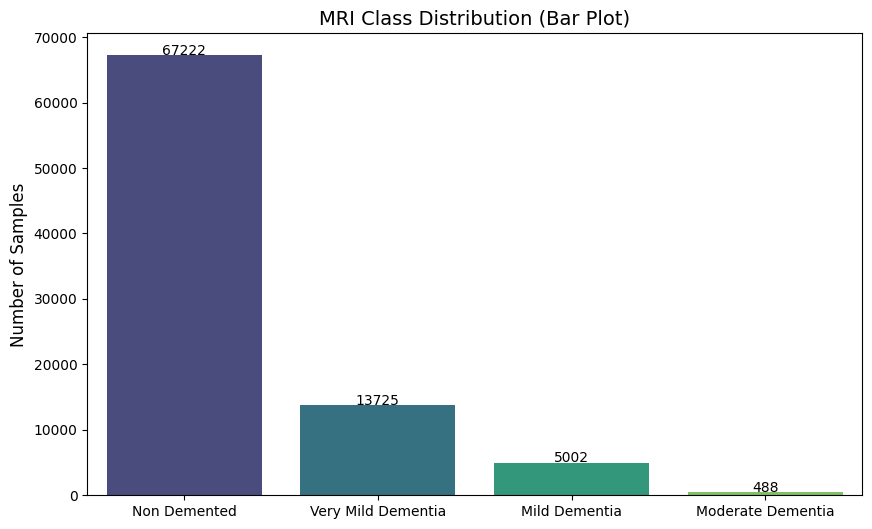

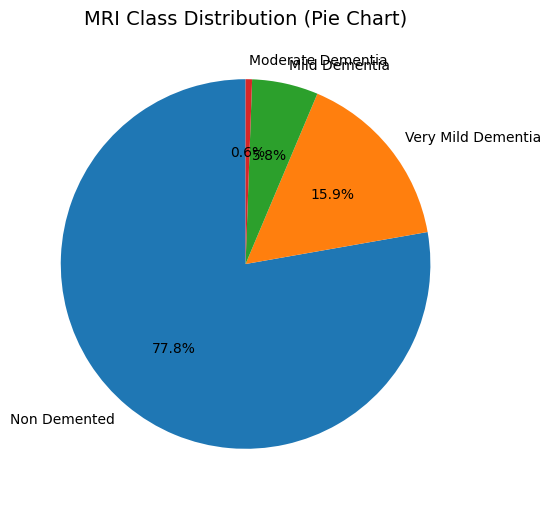

In [13]:
config = DatasetConfig(
    base_dir="imagesoasis/Data",
    num_workers=6,
    valid_extensions=('.png', '.jpg', 'jpeg')
)

# Build dataset
builder = MedicalImageDatasetBuilder(config)
df = builder.build_dataframe()

# Perform analysis
analysis = builder.analyze_dataset(df)


analyzer = AutoMRIDistributionAnalyzer(df, target_column='label')
analyzer.generate_report()

In [14]:
class NeuroimagingTransforms:
  def __init__(
      self,
      image_size: Tuple[int, int] = (256, 256),
      mean: float = 0.0,
      std: float = 1.0,
      apply_augmentation: float = 0.5
  ):
    self.image_size = image_size
    self.mean = mean
    self.std = std
    self.apply_augmentation = apply_augmentation

    # Base transform (always applied)
    self.base_transform = self._build_base_transform(mean, std)

  def _build_base_transform(self, mean: float, std: float) -> T.Compose:
    return T.Compose([
        T.ToPILImage(),
        T.Resize(self.image_size, interpolation=T.InterpolationMode.BILINEAR),
        T.Grayscale(num_output_channels=1), # Ensure single channel for MRI
        T.ToTensor(),
        T.Lambda(lambda x:  (x - mean) / std), # Custom normalization
        T.Lambda(self._remove_outliers), # Remove extreme values , # 3σ outlier removal
        # T.Lambda(self._intensity_scale) # MRI-specific intensity scaling
    ])

  # MRI-speciic transformation methods
  # Gaussian-distributed ~99.7% within ±3σ
  def _remove_outliers(self, x: torch.Tensor) -> torch.Tensor:
    return torch.clamp(x, -3 * self.std, 3 * self.std)

  # def _intensity_scale(self, x: torch.Tensor) -> torch.Tensor:
  #   """Modality-specific intensity scaling"""
  #   if self.modality == 'T1':
  #     return torch.sigmoid(x * 1.5)
  #   elif self.modality == 'T2':
  #     return torch.sigmoid(x * 0.8)

  #   return x

  def _build_augmentation_pipeline(self) -> T.Compose:
    """Clinically relevant augmentations for neuroimaging"""
    return T.Compose([
        T.RandomAffine(degrees=2, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        T.Lambda(self._add_gaussian_noise) # Simulate acquisition variability
    ])

  @staticmethod
  def _add_gaussian_noise(x: torch.Tensor, noise_level: float = 0.01) -> torch.Tensor:
    """Add controlled Gaussian noise"""
    return x + torch.randn_like(x) * noise_level

  def __call__(self, x: np.ndarray) -> torch.Tensor:
    x = self.base_transform(x)
    # if self.augmentation_transform:
    #   x = self.augmentation_transform(x)
    return x

[ ]
class FeatureExtractor:
  """Multimodal feature extraction for neuroimaging data"""

  def __init__(self):
    self.hog_params = {
        'orientations': 9,
        'pixels_per_cell': (8, 8),
        'cells_per_block': (2, 2),
        'channel_axis': None
    }

    self.lbp_params = {
        'P': 8,
        'R': 1,
        'method': 'uniform'
    }

  def extract_hog(self, image: np.ndarray) -> np.ndarray:
    """Histogram of Oriented Gradients"""
    return hog(image, **self.hog_params)

  def extract_lbp(self, image: np.ndarray) -> np.ndarray:
    """Local binary pattern"""
    lbp = local_binary_pattern(image, **self.lbp_params)
    hist, _ = np.histogram(lbp, bins=np.arange(0, 10), density=True)
    return hist

  def extract_histogram(self, image: np.ndarray,bins: int=32) -> np.ndarray:
    """Intensity histogram features"""
    hist, _ = np.histogram(image, bins=bins, range=(0, 1))
    return hist / hist.sum()

  def extract_textuers_feature_(self, image: np.ndarray ) -> np.ndarray:
    """Gray-level Co-occurrence Matrix features"""
    distances = [1, 3, 5]
    angels = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    features = []
    for d in distances:
      for a in angels:
        glcm = graycomatrix((image * 255).astype('uint8'),
                            distances=[d], angles=[a],
                            levels=256, symmetric=True, normed=True)
        for prop in properties:
          print(f"[DEBUG] GLCM Property '{prop}' result shape: {glcm.shape}, value: {glcm}")
          features.append(graycoprops(glcm, prop)[0,0])

    return np.array(features)

  # def extract_morphological(self, image: np.ndarray) -> np.ndarray:
  #         """Morphological and shape features"""
  #         # Threshold image
  #         thresh = image > 0.5
  #         thresh = binary_opening(thresh)  # Remove small noise , Opening=Erosion∘Dilation on binary images (where pixels are either 1 = foreground or 0 = background).

  #         # Region properties
  #         # It performs connected-component labeling (CCL), a graph-theoretic algorithm that assigns
  #         # a unique integer label to each connected region (component) in the binary image.
  #         label_image = label(thresh)
  #         if label_image.max() == 0:  # No regions found
  #             return np.zeros(5)

  #         region = regionprops(label_image)[0]  # Take largest region
  #         return np.array([
  #             region.area,
  #             region.perimeter,
  #             region.eccentricity,
  #             region.solidity,
  #             region.extent
  #         ])

In [15]:
@dataclass
class ModelConfig:
  label_map: Dict[str, int] = field(default_factory=lambda: {
        "Non Demented": 0,
        "Very mild Dementia": 1,
        "Mild Dementia": 2,
        "Moderate Dementia": 3
    })

class BaseNeuroimagingClassifier(ABC):
  """Abstract base class for neuroimaging classifiers"""

  def __init__(
        self,
        config: DatasetConfig = DatasetConfig(),
        model_config: ModelConfig = ModelConfig(),
        transforms: Optional[NeuroimagingTransforms] = None,
        feature_extractor: Optional[FeatureExtractor] = None,
        model: Optional[Any] = None,
        scaler: Optional[StandardScaler] = None
    ):
    print(f"[INIT DEBUG] Created instance of {self.__class__.__name__}")
    self.config = config
    self.model_config = model_config
    self.transforms = transforms or NeuroimagingTransforms()
    self.feature_extractor = feature_extractor or FeatureExtractor()
    self.model = model
    self.scaler = scaler or StandardScaler()
    self.best_params = None



  @abstractmethod
  def get_default_param_grid(self) -> dict:
    """Return parameter grid for hyperparameter tuning"""
    pass

  @abstractmethod
  def get_model_class(self):
    """Return the classifier class"""
    pass

  def extract_features(self, image_paths: List[str]) -> np.ndarray:
    """Extract multimodal features (common to all classifiers)"""
    features = []
    print(f"[DEBUG] extract_features [CLASS-NAME] --- BaseNeuroimagingClassifier ")
    for path in tqdm(image_paths, desc="Extracting features"):
      try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        print(f"[DEBUG] Processing: {path}, img shape: {img.shape}")
        if img is None:
          print(f"[ERROR] Could not read image: {path}")
          continue

        print(f"[DEBUG] Processing: {path}, img shape: {img.shape}")
        # if img.ndim == 2:
        #   img = np.expand_dims(img, axis=-1)
        # img_tensor = self.transforms(img)
        # img_processed = img_tensor.numpy()

        # Convert Numpy grayscale image to PIL grayscale
        pil_img = Image.fromarray(img).convert("L")
        img_processed = self.transforms(pil_img)

        # if img_processed.ndim == 2:
        #   img_processed = img_processed[0] # Remove channel dimension: [1, H, W] → [H, W]
        # elif img_processed.ndim == 3:
        #   raise ValueError(f"Invalid image shape: {img_processed.shape}")

        feat_dict = {
            'hog': self.feature_extractor.extract_hog(img_processed),
            'lbp': self.feature_extractor.extract_lbp(img_processed),
            'histogram': self.feature_extractor.extract_histogram(img_processed),
            'texture': self.feature_extractor.extract_textuers_feature_(img_processed),
            'morphological': self.feature_extractor.extract_morphological(img_processed)
        }

        combined_feat = np.concatenate([v for v in feat_dict.values()])
        features.append(combined_feat)

      except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

    return np.array(features)

  def _compute_elite_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Comute comprehensive metrics for clinical research"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'kappa': cohen_kappa_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
    }

    return metrics

  def train(self, df: pd.DataFrame) -> dict:
    """Common training procedure with algorithm-specific parameters"""
    print(f"[DEBUG] extract_features [CLASS-NAME] --- BaseNeuroimagingClassifier")
    X = self.extract_features(df['image_path'].values)
    y = df['label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=self.config.test_size,
        random_state=self.config.random_seed,
        stratify=y
    )
    X_train = self.scaler.fit_transform(X_train)
    X_test = self.scaler.transform(X_test)

    pipeline = Pipeline([
        ('clf', self.get_model_class())
    ])

    grid_search = GridSearchCV(
        pipeline,
        self.get_default_param_grid(),
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=self.config.num_workers,
        verbose=3
    )

    print(f"Starting {self.__class__.__name__} training")
    grid_search.fit(X_train, y_train)
    self.model = grid_search.best_estimator_
    self.best_params = grid_search.best_params_

    y_pred = self.model.predict(X_test)
    metrics = self._compute_elite_metrics(y_test, y_pred)

    return metrics

In [16]:
class KNNeuroimagingClassifier(BaseNeuroimagingClassifier):
  """KNN implementation with neuroimaging-optimized parameters"""

  # def __init__(self, config: DatasetConfig):
  #   super().__init__(config)
  #   print("[INIT DEBUG] KNNeuroimagingClassifier initialized with config")

  def get_default_param_grid(self) -> dict:
    return {
        'clf_n_neighbors': [3, 5, 7, 9, 11, 13],
        'clf_weights': ['uniform', 'distance'],
        'clf_metric': ['euclidean', 'manhattan', 'minkowski'],
        'clf_p': [1,2],
        'clf_algorithm': ['auto', 'ball_tree', 'kd_tree']
    }

  def get_model_class(self):
    return KNeighborsClassifier

In [17]:
class SVMNeuroimagingClassifier(BaseNeuroimagingClassifier):
  """SVM implementation with medical imaging optimizations"""


  def get_default_param_grid(self)-> dict:
    return  {
      'clf__C': [0.1, 1, 10, 100], # C Parameter regularization parameter of the SVM
      'clf__kernel': ['linear', 'rbf', 'poly'], # kernel function
      'clg__gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1],
      'clf__class_weight': [None, 'balanced'],
      'clf__probability': [True], # Enable probability estimates
    }

  def get_model_class(self):
    return SVC

In [18]:
class XGBoostNeuroimagingClassifier(BaseNeuroimagingClassifier):
  """XGBoost implementation with medical-specific parameters"""

  def get_default_param_grid(self) -> dict:
    return {
        'clf__n_estimators': [100, 200],   # Number of trees (weak learners) in the ensemble
        'clf__max_depth': [3, 6, 9],  # Maximum depth of each decision tree
        'clf__learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage applied to each tree's contribution
        'clf__subsample': [0.6, 0.8, 1.0],  # Fraction of training samples used for fitting each tree (bagging)
        'clf__colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features randomly sampled for each tree
        'clf__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a split
    }

  def get_model_class(self):
    return XGBClassifier

In [19]:
class RFNeuroimagingClassifier(BaseNeuroimagingClassifier):
  """Random Forest implementation for clinical applications"""

  def get_default_param_grid(self) -> dict:
    return {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
        'clf__max_features': ['sqrt', 'log2', 0.3, 0.5]
    }

  def get_model_class(self):
     return RandomForestClassifier

In [20]:
class NeuroimagingClassifierFactory:
  """Factory to create different classifier types with consitent interface"""

  @classmethod
  def create_classifier(cls, model_type: str, config: DatasetConfig = None) -> BaseNeuroimagingClassifier:
    """
    Available model types:
    - 'knn': K-Nearest Neighbors
    - 'svm': Support Vector Machine
    - 'rf': Random Forest
    - 'xgb': XGBoost
    """

    model_map = {
        'knn': KNNeuroimagingClassifier,
        'svm': SVMNeuroimagingClassifier,
        'rf': RFNeuroimagingClassifier,
        'xgb': XGBoostNeuroimagingClassifier
    }

    if config is None:
      config = DatasetConfig()

    if model_type not in model_map:
      raise ValueError(
          f"[Factory Error] Unknown model_type '{model_type}'."
          f"Valid options are: {list(model_map.keys())}"
      )

    model_class = model_map[model_type]

    print("DEBUG: model_class =", model_class)
    print("DEBUG: base classes =", model_class.__bases__)
    print("DEBUG: issubclass =", issubclass(model_class, BaseNeuroimagingClassifier))

    # Confirm class is subclass of BaseNeuroimagingClassifier
    if not issubclass(model_class, BaseNeuroimagingClassifier):
      raise TypeError(
          f"[Factory Error] Class {model_class.__name__} must inherit from BaseNeuroimagingClassifier"
      )

    if model_type.lower() not in model_map:
      raise ValueError(f"Unknown model type: {model_type}. Available options: {list(model_map.keys())}")

    return model_map[model_type.lower()](config)

In [21]:
class ComparativeExecutiveAnalytics:
  """Compare multiple models for executive decision making"""

  def __init__(self, metrics: dict, label_map: dict):
     """
        metrics_dict: {'knn': knn_metrics, 'svm': svm_metrics, ...}
     """
     self.metrics = metrics
     self.label_map = {v:k for k,v in label_map.items()}

  def generate_comparative_report(self) -> str:
        """Generate board-ready model comparison"""
        report = [
            "=== NEUROIMAGING MODEL COMPARATIVE ANALYSIS ===",
            "\nModel Performance Summary:",
            *self._get_performance_table(),
            "\nKey Findings:",
            *self._get_key_findings()
        ]
        return "\n".join(report)

  def _get_perfomance_table(self) -> List[str]:
    headers = ["Model", "Balanced Acc", "Kappa", "MCC", "Best Class (F1)", "Worst Class (F1)"]
    rows = []

    for model_name, metrics in self.metrics.items():
      best_class = max(metrics['class_metrics'].items(), key=lambda x: x[1]['f1'])
      worst_class = min(metrics['class_metrics'].items(), key=lambda x: x[1]['f1'])

      rows.append([
          model_name.upper(),
          f"{metrics['balanced_accuracy']:.3f}",
          f"{metrics['kappa']:.3f}",
          f"{metrics['mcc']:.3f}",
          f"{self.label_map[best_class[0]]}: {best_class[1]['f1']:.2f}",
          f"{self.label_map[worst_class[0]]}: {worst_class[1]['f1']:.2f}"
      ])

    # Format as table
    col_widths = [max(len(str(x)) for x in col) for col in zip(headers, *rows)]

    table = [
        " | ".join(f"{h:<{w}}" for h, w in zip(headers, col_widths)),
        "-" * sum(col_widths) + "-" * (3 * (len(col_widths) - 1)),
        *[" | ".join(f"{c:<{w}}" for c, w in zip(row, col_widths)) for row in rows]
    ]

    return table

  def _get_key_findings(self) -> List[str]:
    """Generate data-driven comparative insights"""
    findings = []

    # Find best overall model
    best_model = max(self.metrics.items(),
                     key=lambda x: x[1]['balanced_accuracy'])

    findings.append(
        f"- Best overall performance: {best_model[0].upper()}"
        f"(Balanced Acc={best_model[1]['balanced_accuracy']:.3f})"
    )

    # Find most robust model (least variance in class performance)
    # measures the spread of F1 scores around their mean — lower means the model performs more consistently across all classes.
    most_robust = min(self.metrics.items(),
                      key=lambda x: np.std([c['f1'] for c in x[1]['class_metrics'].values()]))

    findings.append(
        f" - Most consistent across classes: {most_robust[0].upper()} "
        f"(Std F1={np.std([c['f1'] for c in most_robust[1]['class_metrics'].values()]):.3f})"
    )

    # Identify best model for each class
    for class_name, class_id in self.label_map.items():
      best_for_class = max(self.metrics.items(),
                           key=lambda x:x[1]['class_metrics'][class_id]['f1'])

      findings.append(
          f"- Best for {class_name}: {best_for_class[0].upper()} "
          f"(F1={best_for_class[1]['class_metrics'][class_id]['f1']:.2f})"
      )

      return findings

  def plot_comparative_analysis(self):
    """Generate comparative visualization"""
    plt.figure(figsize=(12,8))

    # Radar chart comparing class-wise performance
    categories = list(self.label_map.values())
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.ylim(0,1)

    for model_name, metrics in self.metrics.items():
      values = [metrics['class_metrics'][i]['f1'] for i in range(len(categories))]
      values += values[:1]
      ax.plot(angles, values, linewidth=1, linestyle='solid',
              label=model_name.upper())
      ax.fill(angles, values, alpha=0.1)

    plt.title("Class-wise F1 Score Comparison", size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

In [ ]:
def main():
    print("=== Flexible Neuroimaging Classification ===")

    # Data preparation
    builder = MedicalImageDatasetBuilder()
    df = builder.build_dataframe()
    print(f"Shape :  {df.shape}")
    print(f"\nHead: \n{df.head(5)}")
    print(f"\nTail: \n{df.tail(5)}")
    print(f"\nData Type: \n{df.dtypes}")
    # df = df[df['valid']].reset_index(drop=True)

    # Train multiple models
    models_to_test = ['knn', 'svm', 'xgb']  # Add 'xgb' if needed
    metrics = {}

    for model_type in models_to_test:
        print(f"\n=== Training {model_type.upper()} ===")
        classifier = NeuroimagingClassifierFactory.create_classifier(model_type)
        print(f"[DEBUG] About to train {classifier.__class__.__name__}")
        metrics[model_type] = classifier.train(df)

        # Save each model
        classifier.save_model(f"neuro_{model_type}_model.pkl")
        print(f"Saved {model_type.upper()} model")

    # Comparative analysis
    print("\n=== Comparative Analysis ===")
    comparative = ComparativeExecutiveAnalytics(metrics, builder.label_map)
    print(comparative.generate_comparative_report())
    comparative.plot_comparative_analysis()

if __name__ == "__main__":
    main()